# Previsione di opportunità di Cross Sell di assicurazioni  

Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.  

Il dataset è composto dalle seguenti proprietà:  

id: id univoco dell'acquirente.  
Gender: sesso dell'acquirente.  
Age: età dell'acquirente.  
Driving_License: 1 se l'utente ha la patente di guida, 0 altrimenti.  
Region_Code: codice univoco della regione dell'acquirente.  
Previously_Insured: 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.  
Vehicle_Age: età del veicolo  
Vehicle_Damage: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.  
Annual_Premium: la cifra che l'utente deve pagare come premio durante l'anno.  
Policy_Sales_Channel: codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)  
Vintage: numero di giorni dalla quale l'utente è cliente dell'azienda.  
Response: 1 se l'acquirente ha risposto positivametne alla proposta di vendità, 0 altrimenti. 

L'obiettivo del modello è prevedere il valore di Response.  




In [1]:

# Import delle librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTENC

In [2]:
# Seed per la riproducibilità
RANDOM_SEED = 0

In [3]:
# Caricamento del dataset
df = pd.read_csv("insurance_cross_sell.csv", index_col=0)

In [4]:
# controllo head del dataset.
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
#describe per studiare gli indici.
df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


Primo controllo per i nulli, non presenti.

In [6]:
df.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Controlliamo il VIF, per capire se c'è multicollinearità tra le variabili. Definiamo una funzione apposita.

In [7]:
# Calcolo del VIF per ciascuna caratteristica del dataset
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    
    # Calcolo del VIF per ciascuna colonna
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

numeric_df = df.select_dtypes(include=[np.number])
vif_data = calculate_vif(numeric_df.drop(["Response"], axis=1))
print(vif_data)

                feature        VIF
0                   Age  10.452843
1       Driving_License  35.186725
2           Region_Code   4.954016
3    Previously_Insured   1.986280
4        Annual_Premium   4.174542
5  Policy_Sales_Channel   7.749016
6               Vintage   4.373156


In [8]:
def encode_features(df, encode_type="label", features_to_encode=[]):
    for feature in features_to_encode:
        if encode_type == "label":
            df[feature] = LabelEncoder().fit_transform(df[feature])
        elif encode_type == "onehot":
            df = pd.get_dummies(df, columns=[feature])
    return df

Per il momento solo Driving_License mostra una forte correlazione.  
Passiamo ora ad un Label encoder per le variabili categoriche, che ci permetterà di lanciare una matrice di correlazione.

In [9]:
# Preprocessing - esempio di applicazione funzione di codifica e VIF
df = encode_features(df, encode_type="label", features_to_encode=["Gender", "Vehicle_Damage"])
df = encode_features(df, encode_type="onehot", features_to_encode=["Vehicle_Age"])

<Axes: >

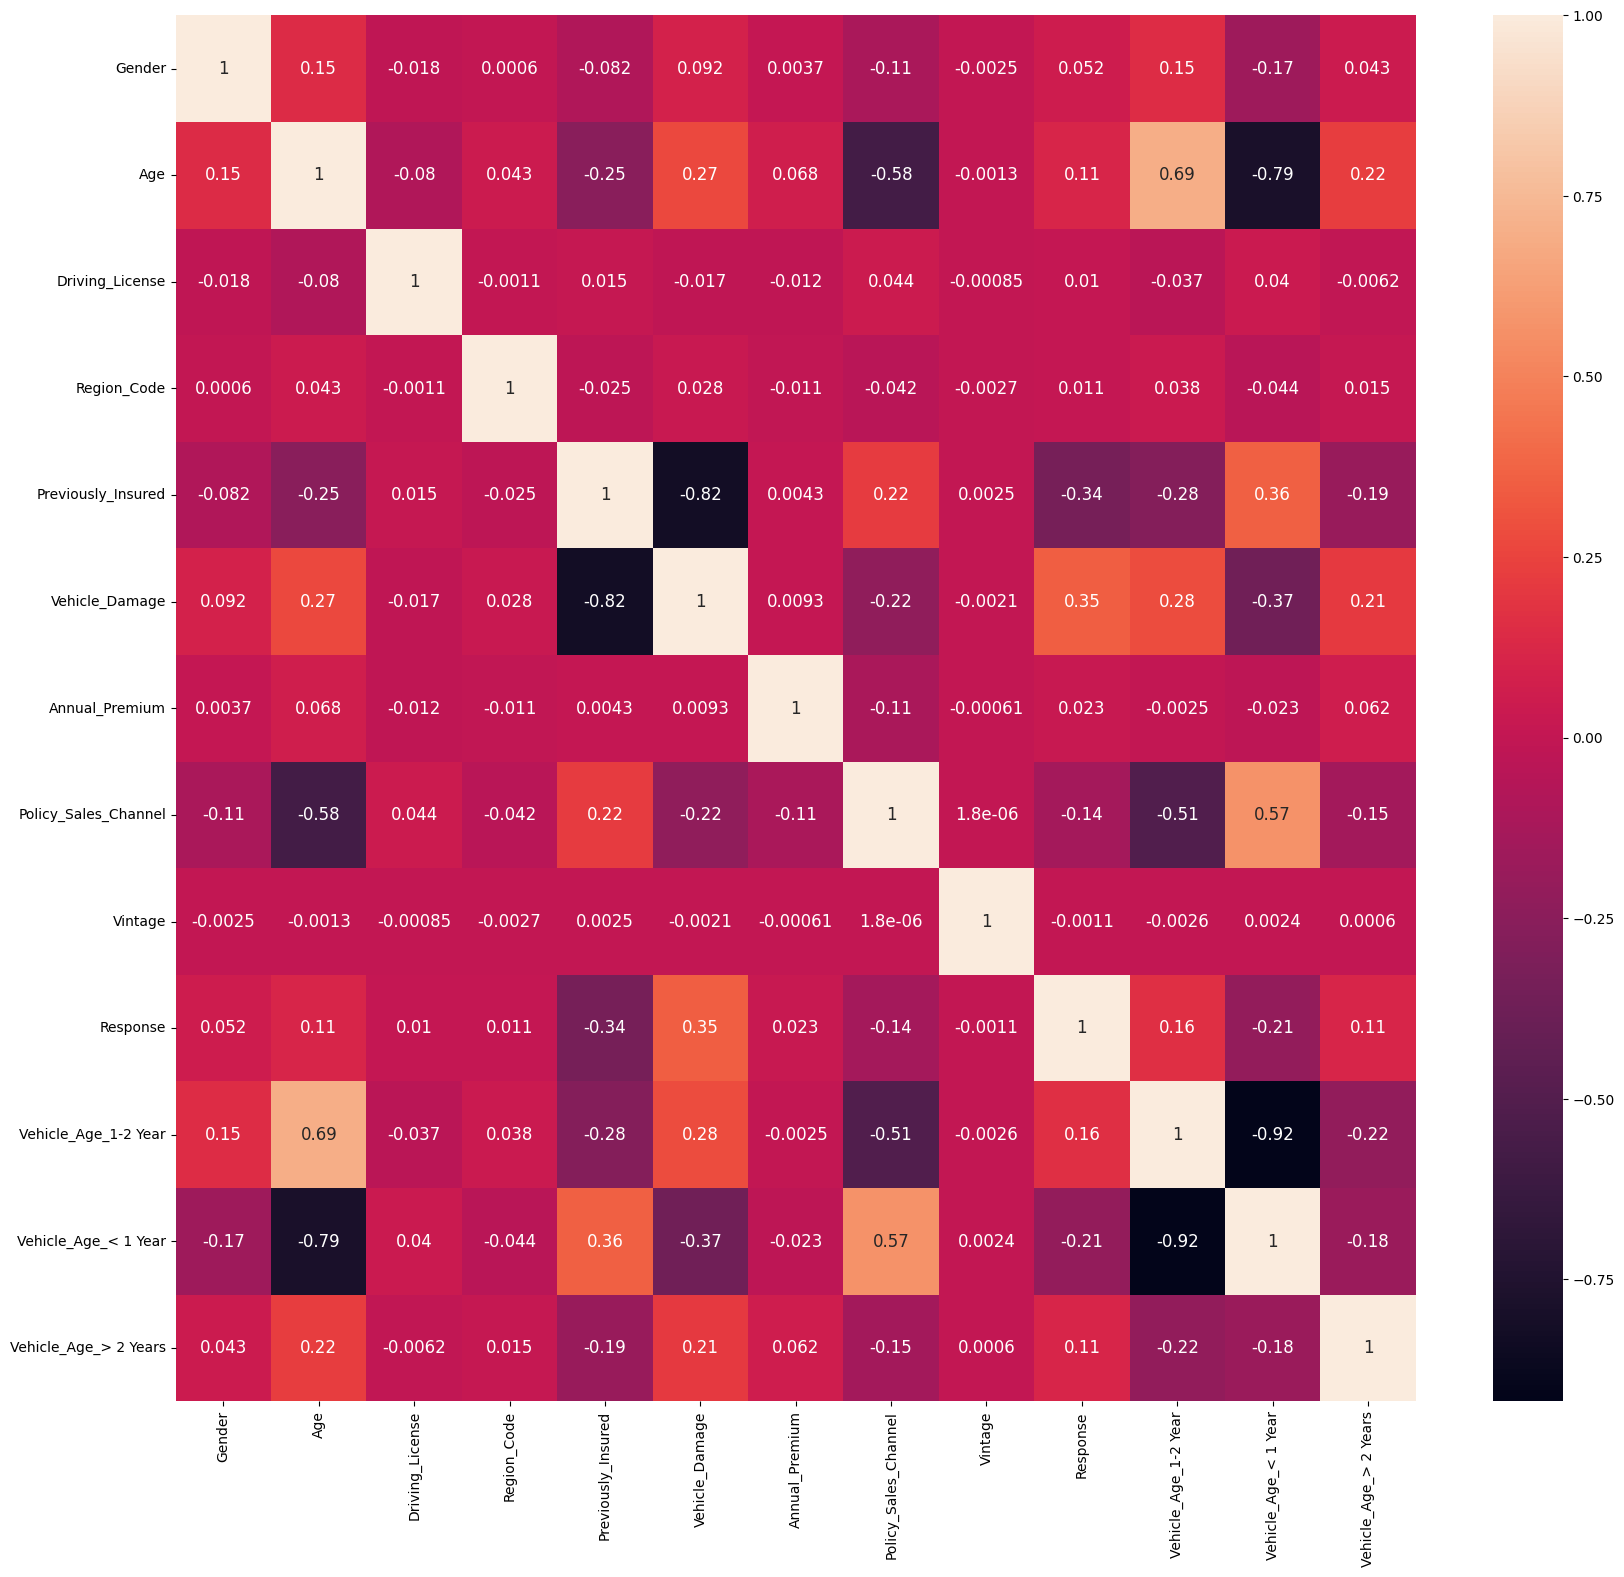

In [10]:
# Studio della correlazione, considerazione stratificazione e VIF
plt.figure(figsize=(20,18))
sns.heatmap(df.corr(), annot=True, annot_kws={"size":12})

Studiamo la correlazione tra variabili usando una matrice.

Possiamo notare che:  
- Vista la correlazione molto bassa, il genere del cliente non ha che un minimo impatto sulla decisione di acquistare l'assicurazione.
- Con una correlazione negativa di -0.52 i clienti sono propensi a possedere veicoli relativamente più nuovi.
- La presenza di un legame leggermente positivo tra l'età dei clienti e la probabilità che rispondano positivamente.
- Dato il coefficiente negativo tra Previously_Insured e Response, i clienti che erano precedentemente assicurati sono meno propensi ad accettare un'offerta di assicurazione.
- I clienti i cui veicoli hanno subito danni in passato sono più propensi ad acquistare l'assicurazione.
- C'è una forte correlazione negativa (-0.824143) tra Previously_Insured e Vehicle_Damage, suggerendo che se un cliente ha già una polizza assicurativa, è meno probabile che il suo veicolo abbia subito danni. Questo potrebbe indicare che individui già assicurati tendono a essere più cauti o a guidare veicoli meno esposti a danni.
- Vehicle_Age < 1 Year e Age hanno una forte correlazione negativa (-0.787775), indicando che i clienti più giovani tendono a possedere veicoli più nuovi. Questo potrebbe riflettere pattern di acquisto o preferenze basate sull'età.
- Previously_Insured e Vehicle_Damage sul Response: Queste due variabili hanno rispettivamente correlazioni significative negative (-0.341170) e positive (0.354400) con la variabile Response, che potrebbe indicare se un cliente è interessato ad acquistare una polizza. La correlazione suggerisce che i clienti il cui veicolo ha subito danni e non sono precedentemente assicurati hanno maggiori probabilità di rispondere positivamente.

Continuiamo con il Preprocessing creando nuove variabili e modificandone altre.

In [11]:
df['Annual_Premium_Category'] = pd.qcut(df['Annual_Premium'], 4, labels=False)
df['Region_Code_Freq'] = df.groupby('Region_Code')['Region_Code'].transform('count') / len(df)
df = pd.concat([df.drop('Annual_Premium_Category', axis=1), pd.get_dummies(df['Annual_Premium_Category'], prefix='premium')], axis=1)

In [12]:
kmeans = KMeans(n_clusters=5, random_state=RANDOM_SEED)
df['Cluster'] = kmeans.fit_predict(df[['Age', 'Annual_Premium']]) # creiamo 5 cluster per Age e Annual_premium

In [13]:
df = df.drop("Driving_License",axis=1) #eliminiamo la variabile con alta multicollinearità.

In [14]:
df.head()

,Gender,Age,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Region_Code_Freq,premium_0,premium_1,premium_2,premium_3,Cluster
id,,,,,,,,,,,,,,,,,,
1,1,44,28.0,0,1,40454.0,26.0,217,1,False,False,True,0.279225,False,False,False,True,0
2,1,76,3.0,0,0,33536.0,26.0,183,0,True,False,False,0.024274,False,False,True,False,3
3,1,47,28.0,0,1,38294.0,26.0,27,1,False,False,True,0.279225,False,False,True,False,0
4,1,21,11.0,1,0,28619.0,152.0,203,0,False,True,False,0.024224,False,True,False,False,3
5,0,29,41.0,1,0,27496.0,152.0,39,0,False,True,False,0.047921,False,True,False,False,3


Procediamo con un nuovo controllo per la multicollinearità, che adesso risulta sotto controllo.

In [15]:
numeric_df = df.select_dtypes(include=[np.number])
vif_data = calculate_vif(numeric_df.drop(["Response"], axis=1))
print(vif_data)

                feature       VIF
0                Gender  2.200094
1                   Age  7.610553
2           Region_Code  4.655259
3    Previously_Insured  4.845065
4        Vehicle_Damage  5.414120
5        Annual_Premium  4.742106
6  Policy_Sales_Channel  5.241675
7               Vintage  4.122334
8      Region_Code_Freq  2.285154
9               Cluster  3.259653


Ora che abbiamo sistemato molte delle nostre variabili, cancellandone alcune e creandone delle altre, eseguiamo una nuova matrice di correlazione.

<Axes: >

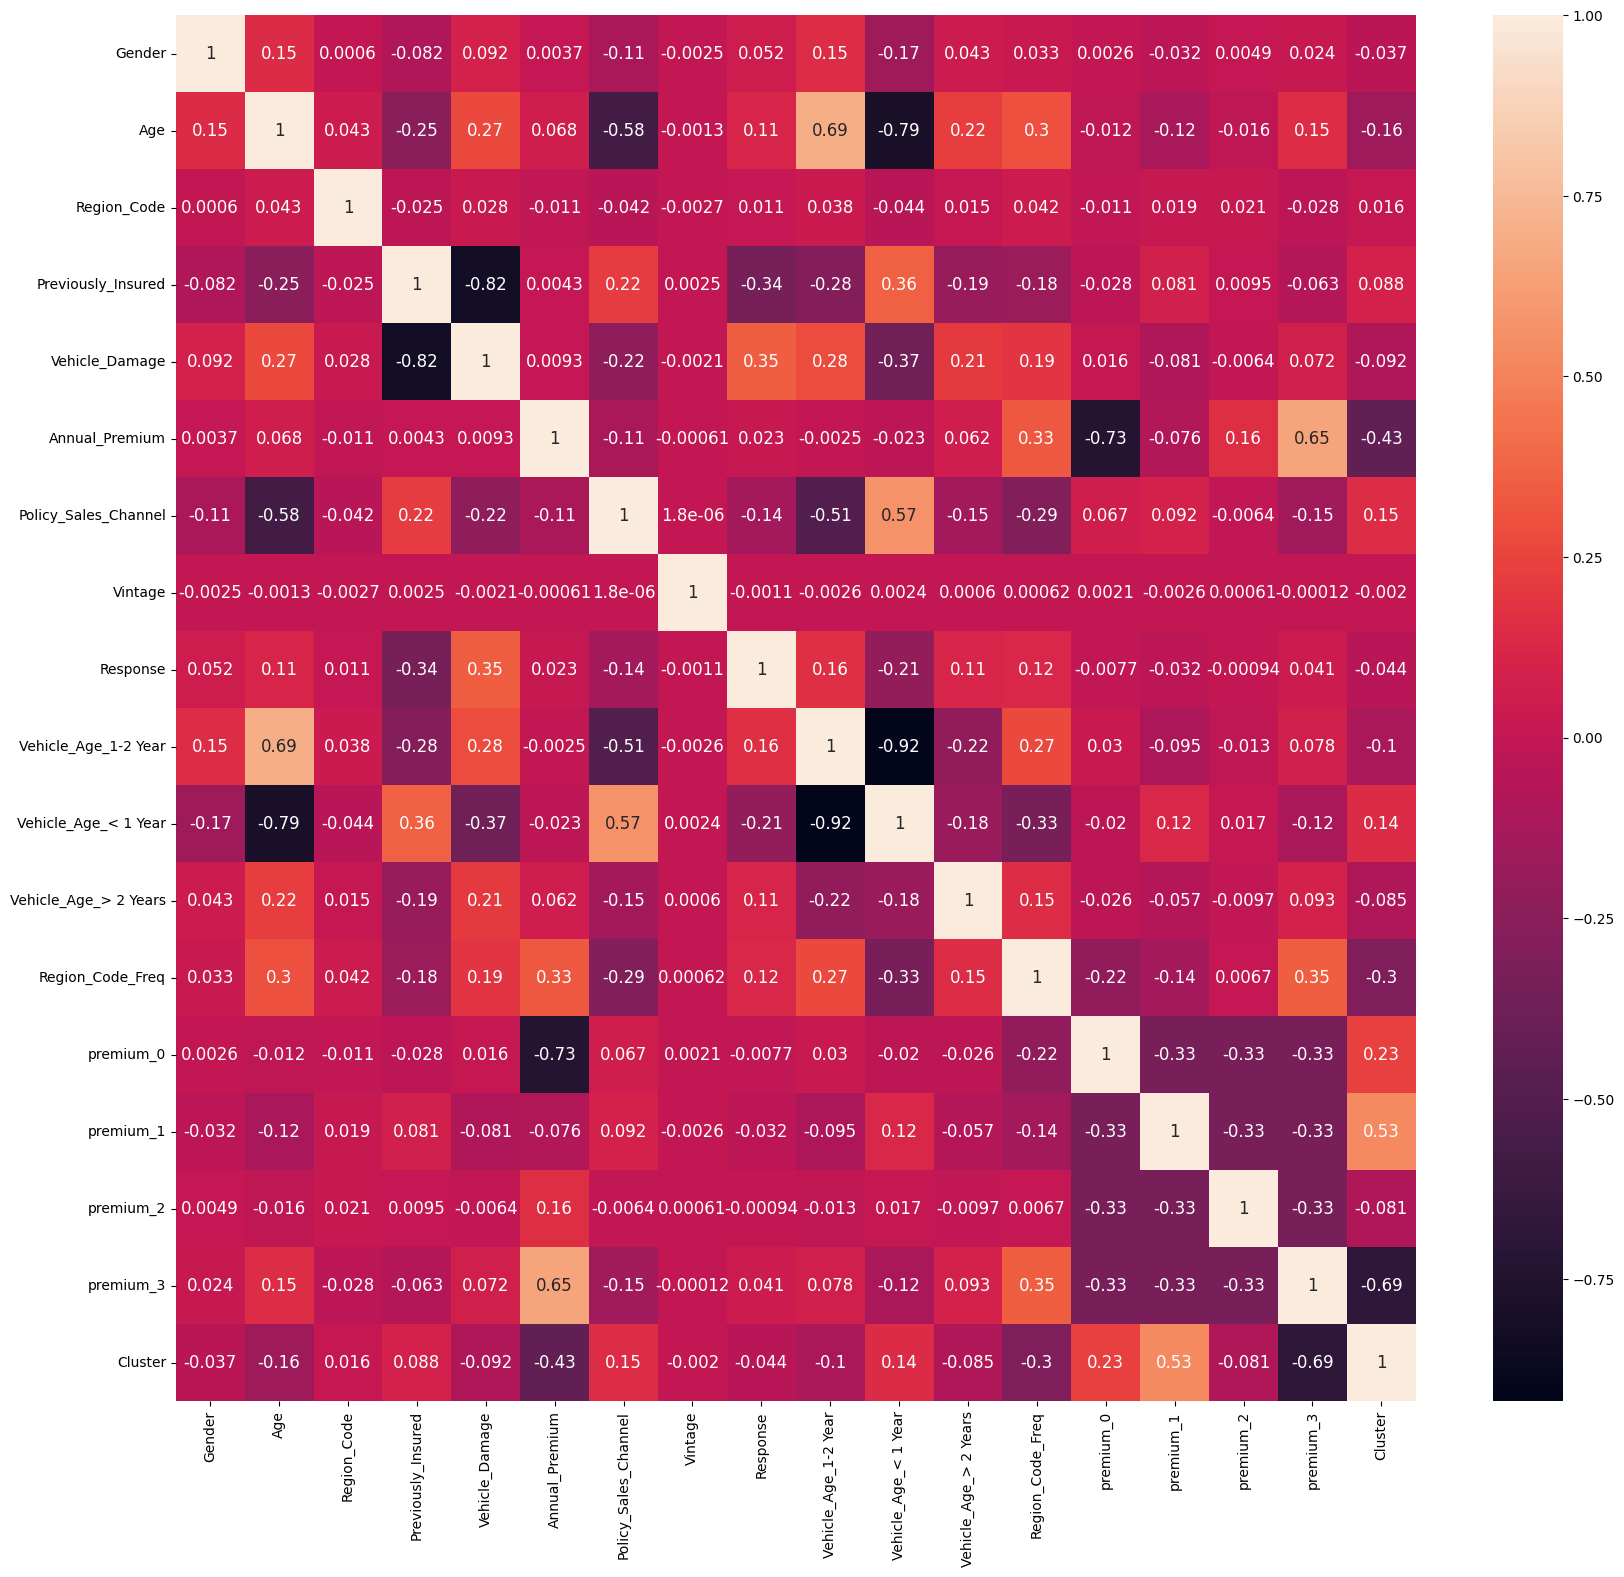

In [16]:
data = df.corr().values
plt.figure(figsize=(20,18))
sns.heatmap(df.corr(),
            annot=True, annot_kws={"size":12})

Possiamo notare che:

- E' presente una forte correlazione negativa tra Previously_Insured e Vehicle_Damage, il che potrebbe significare che i clienti che non sono assicurati precedentemente hanno maggiori probabilità di aver subito danni al loro veicolo, e viceversa.
- Age e Policy_Sales_Channel ci mostrano una correlazione negativa, portandoci a pensare che gruppi di età diversi preferiscono canali di vendita diversi.
- Annual_Premium e premium_0 ci mostrano una correlazione di -0.732241, evidenziando una significativa correlazione negativa. Potrebbe indicare che man mano che l'Annual Premium aumenta, la probabilità di appartenere alla categoria "premium_0" diminuisce.


Passiamo alla divisione del dataset con la variabile Target.

In [17]:
X = df.drop('Response', axis=1)
y = df['Response']

In [18]:
y.value_counts()

Response
0    334399
1     46710
Name: count, dtype: int64

Successivamente usiamo train_split_test per suddividere tra i set di training e di test, con una grandezza del test del 15% del totale.

In [19]:
# Divisione in training set e test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.15,
                                                        random_state=RANDOM_SEED, stratify=y)

Applichiamo lo smote, ovvero l'oversampling, a X_train e y_train.

In [20]:
smote = SMOTE(random_state=RANDOM_SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Nuovo controllo dei nulli, non presenti. Questo viene fatto perché si è notato che SMOTE può, saltuariamente, presentare problemi con alcune variabili categoriche.

In [21]:
print(X_train_res.isnull().sum())


Gender                   0
Age                      0
Region_Code              0
Previously_Insured       0
Vehicle_Damage           0
Annual_Premium           0
Policy_Sales_Channel     0
Vintage                  0
Vehicle_Age_1-2 Year     0
Vehicle_Age_< 1 Year     0
Vehicle_Age_> 2 Years    0
Region_Code_Freq         0
premium_0                0
premium_1                0
premium_2                0
premium_3                0
Cluster                  0
dtype: int64


Creiamo una pipeline, in cui incapsuleremo più passaggi che verranno applicati nell'ordine.  
Il primo passo sarà la standardizzazione, il secondo la creazione di un modello di regressione logistica. In questo particolare caso il peso delle classi è stato regolato manualmente non diverse prove. La classe 0 ha ora un peso di 0.66, la classe 1 un peso di 0.24.  
Viene applicata la regolarizzazione Ridge, per prevenire l'overfitting, e viene utilizzato il solver liblinear che è adatto ai problemi di classificazione binaria.  
Max_iter aumenta la soglia massima di iterazioni per gli algoritmi, mentre C=10 rappresenta l'inverso della forza di regolarizzazione (valori più piccoli specificano una regolarizzazione più forte).

In [22]:
# Creazione della pipeline
pipeline = make_pipeline(
            StandardScaler(), #Standardizzazione
            LogisticRegression(class_weight={0: 0.66, 1: 0.34}, random_state=RANDOM_SEED, penalty='l2', solver='liblinear', max_iter=10000, C=10))

In [23]:
# Cross-Validation
cv_scores = cross_val_score(pipeline, X_train_res, y_train_res, cv=5, scoring='roc_auc')
print(f"Media AUC-ROC Scores della Cross-Validation: {np.mean(cv_scores)}")

Media AUC-ROC Scores della Cross-Validation: 0.9051046326267109


Procediamo all'addestramento sui set di training su cui abbiamo precedentemente passato SMOTE.

In [24]:
# Addestramento del modello sul training set
pipeline.fit(X_train_res, y_train_res)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=10, class_weight={0: 0.66, 1: 0.34},
                                    max_iter=10000, random_state=0,
                                    solver='liblinear'))])

Valutiamo le performance del nostro modello sui dati di test.

In [25]:
y_test_pred = pipeline.predict(X_test)  # generiamo le predizioni
y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1] # e qui le probabilità che ogni osservazione appartenga alla classe 1.
# test di accuracy, area sotto la curva ROC e matrice di confusione.
accuracy_test = accuracy_score(y_test, y_test_pred) 
auc_roc_test = roc_auc_score(y_test, y_test_pred_proba)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

In [26]:
print("Report di classificazione sul test set:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy sul test set: {accuracy_test}")
print(f"AUC-ROC sul test set: {auc_roc_test}")
print("Matrice di confusione sul test set:")
print(conf_matrix_test)

Report di classificazione sul test set:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     50160
           1       0.31      0.42      0.36      7007

    accuracy                           0.82     57167
   macro avg       0.61      0.64      0.63     57167
weighted avg       0.84      0.82      0.83     57167

Accuracy sul test set: 0.8172722024944461
AUC-ROC sul test set: 0.8206154576797091
Matrice di confusione sul test set:
[[43803  6357]
 [ 4089  2918]]


Classe 0:
- il nostro modello ha una precisione dell'92%, ovvero la percentuale delle predizioni corrette per la classe;
- Il recall è dell'87%, il che indica la percentuale dei casi correttamente identificati dal modello;
- la media armonica tra i due test, l'F1, è dell'89%. Un buon risultato, equilibrato.

Classe 1:
- la precisione scende al 32%.
- il recall ci indica che il modello riesce ad identificare il 42% dei veri casi positivi.
- questi bassi valori si rispecchiano nell'F1-score. Il modello dimostra chiare difficoltà nel predire i valori per questa classe.

Ciononostante il modello dimostra una buona accuracy generale, del 81,82%. Lo stesso si può dire per le medie pesate.
L'AUC-ROC è piuttosto elevato, pertanto il modello ha una buona capacità di discernere tra le classe 0 e 1. Nonostante la bassa precisione per la classe 1, il modello dimostra una buona capacità discriminativa.

La matrice di confusione ci mostra come quasi seimila casi sono stati erroneamente interpretati come classe 1, dovuto alla bassa precisione per la classe 1.

E ora valutiamo le performance sui dati di train.

In [27]:
y_train_pred = pipeline.predict(X_train) # generiamo le predizioni
y_train_pred_proba = pipeline.predict_proba(X_train)[:, 1] # e qui le probabilità che ogni osservazione appartenga alla classe 1.
# test di accuracy, area sotto la curva ROC e matrice di confusione.
accuracy_train = accuracy_score(y_train, y_train_pred)
auc_roc_train = roc_auc_score(y_train, y_train_pred_proba)
conf_matrix_train = confusion_matrix(y_train, y_train_pred)

In [28]:
print("Report di classificazione sul train set:")
print(classification_report(y_train, y_train_pred))
print(f"Accuracy sul train set: {accuracy_train}")
print(f"AUC-ROC sul train set: {auc_roc_train}")
print(conf_matrix_train)

Report di classificazione sul train set:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89    284239
           1       0.32      0.42      0.36     39703

    accuracy                           0.82    323942
   macro avg       0.62      0.65      0.63    323942
weighted avg       0.84      0.82      0.83    323942

Accuracy sul train set: 0.8172327144982744
AUC-ROC sul train set: 0.8225531786458491
[[247995  36244]
 [ 22962  16741]]


Classe 0:
- Si osserva una precisione del 92% e un recall dell'87%, con un F1-score di 0.89. Questi valori sono identici a quelli osservati sul test set, suggerendo che il modello ha una performance simile su entrambi i set per la classe 0.

Classe 1: 
- Anche per la classe 1, la precisione (32%), il recall (42%) e l'F1-score (0.36) sul train set riflettono quasi esattamente le prestazioni sul test set. Questi risultati indicano che il modello non soffre significativamente di overfitting o underfitting in termini di prestazioni su classi specifiche.

Accuracy: 
- L'accuratezza sul train set è del 81,78%, quasi la stessa osservata sul test set (81.82%), suggerendo coerenza nelle prestazioni generali del modello.

Macro e Weighted Avg:
- Anche queste medie riflettono i risultati del test set molto da vicino, sostenendo l'idea che il modello generalizza bene sui dati non visti.

AUC-ROC sul Train Set:
- Con un valore AUC-ROC di 0.8225, le prestazioni sul train set sono molto simili a quelle sul test set (0.821). Questo conferma ulteriormente la buona capacità del modello di discriminare tra le classi, mantenendo una coerenza tra addestramento e valutazione.

La matrice di confusione ci mostra 248335 veri negativi e 35,948 falsi positivi per la classe 0, con 23,059 falsi negativi e 16661 veri positivi per la classe 1. Questi numeri sono proporzionalmente simili a quelli sul test set, indicando che il modello ha una tendenza coerente nel classificare le istanze, indipendentemente da se queste fanno parte del set di addestramento o di valutazione.

___

## CONCLUSIONI

Analizzando il dataset fornito, abbiamo considerato fattori come l'età dell'acquirente e del veicolo, la presenza di patente di guida, esperienze passate di danni al veicolo e altri dati demografici e comportamentali. Il problema della previsione è stato affrontato come un problema di classificazione binaria, tenendo nel mirino la distribuzione tra classi sbilanciate, che è un'osservazione chiave emersa durante l'esplorazione dei dati.

Abbiamo utilizzato tecniche quali la standardizzazione dei dati, l'uso di modelli robusti come la regressione logistica con l'adozione di pesi differenziati per le classi (class_weight), per equilibrare l'impatto delle classi sbilanciate, e l'impiego di metriche adeguate (precisione, recall, F1-score, AUC-ROC) per una valutazione olistica delle prestazioni del modello. La matrice di confusione ha illustrato le capacità di predizione del modello, evidenziando aree di forza e potenziali miglioramenti.

Attraverso queste metodologie, siamo stati capaci di costruire un modello che non solo possiede un'accuratezza generale soddisfacente ma dimostra anche capacità di generalizzazione su dati non visti precedentemente, come si evince dalle analisi condotte sia sul dataset di train che su quello di test. Tallone d'achille del modello è la precisione delle previsioni riguardanti i clienti interessati all'assicurazione veicolo, indicando possibili opportunità di perfezionamento attraverso tecniche avanzate di bilanciamento delle classi o l'esplorazione di modelli più complessi.

Vista l'alta precisione nella previsione per i clienti non interessati lo riteniamo comunque un ottimo modello per il casus in oggetto, in quando avere la certezza di quali clienti non contattare permette al cliente un considerevole risparmio in termini di tempo e risorse.